In [ ]:
!pip install psycopg2-binary
!pip install openpyxl

In [1]:

import os, json

def get_credentials():
    with open(os.path.expanduser("~/.credentials.json"), "r") as read_file:
        credentials = json.load(read_file)
    return credentials

# Ranking articles by citation rate, and plotting citation rates per year

The postgres database contains two tables after the full data import for pubmed.
* records
* referencetable

After the process of computing citationcounts and percentiles, we have two extra tables:
* records
* referencetable
* citationcountswithoutyear
* citationcounts
* pubmed_percentiles


For determining the reputation / trustworthiness of an article, we compute the number of citations for each article.
We are proposing that articles with a certain citation rate that puts them above the _n_th percentile in 'popularity', are those articles that are most relevant.

By joining the above tables we can create a table that contains

<table><th><td>pubmedid</td><td>year</td><td>citationcount</td></th></table>

```sql

/* 
    datadigger.referencetable  has 366K records.
    in order process these in a reasonable time, we're first grouping them by cited pubmed id.

    (Query returned successfully in 6 min 26 secs.)
*/
SELECT pubmed AS PubmedId, COUNT(pubmed) AS citationcount
INTO datadigger.citationcountswithoutyear
FROM datadigger.referencetable 
GROUP BY pubmed

/* 
   Then we create the table citationcounts 
   The glitch is that the Records identifier is pubmedid + '00' - based on the original
   thinking that we would allow multiple data sources (which so far has not materialized).

   The `LEFT JOIN` combined with the `COALESCE` accounts for the fact that some articles are _never_ cited 
   and thus get citationcount = 0.
*/
SELECT SUBSTRING(r.identifier, 1, LENGTH(r.identifier)-2) AS PubmedId, 
COALESCE(rt.citationcount, 0) citationcount, Year
INTO datadigger.citationcounts
FROM datadigger.records r LEFT JOIN datadigger.citationcountswithoutyear rt
ON SUBSTRING(r.identifier, 1, LENGTH(r.identifier)-2)=rt.pubmedid
GROUP BY SUBSTRING(r.identifier, 1, LENGTH(r.identifier)-2), 
COALESCE(rt.citationcount, 0), Year
```

Aggregating this table on another level we can create a curve of citation count vs. year.
We are interested to see the citation count of articles that are in the top _n_ of that year.\
For that reason we want to compute the citation count that corresponds to the _percentiles_ for each year.
The computation of these percentiles _could be_ done with the below SQL statement.

```sql 

ALTER TABLE datadigger.citationcounts ADD COLUMN YearRank INT

WITH RankedCitationCounts AS 
(SELECT
    pubmedid,
    citationcount,
    ROUND(
        PERCENT_RANK() OVER (
			PARTITION BY Year
            ORDER BY citationcount
        ) 
	) percentile_rank
FROM
    datadigger.citationcounts)

UPDATE datadigger.citationcounts  
SET yearrank = rcc.percentile_rank
FROM datadigger.citationcounts cc JOIN RankedCitationCounts rcc
ON cc.pubmedid = rcc.pubmedid
```

The problem with this statement is that this statement does not complete within a reasonable time frame (after a few hours I gave up).
For this reason the program 'ranking' was written in rust. Run it as 

```sh
./ranking --credentials path-to-creds --database postgres-datadigger
```

And it will compute a table `pubmed_percentiles`.

With this table, we can split the documents of each year into percentiles and choose what cut-off to use for each year.

For example, to pick documents above the 15% percentile we do the following query.

```sql
SELECT r.* FROM datadigger.Records r JOIN 
    datadigger.citationcounts cc ON CONCAT(cc.pubmedid,'00') = r.identifier JOIN 
    datadigger.pubmed_percentiles p ON p.citationcount <= cc.citationcount
    WHERE p.percentile = 15
```

We can of course pick any percentile we want.

In [2]:
import psycopg2
import pandas as pd
credentials = get_credentials()

def connect(config):
    conn = None
    """ Connect to the PostgreSQL database server """
    try:
        # connecting to the PostgreSQL server
      conn = psycopg2.connect(
         host=config['host'],
         database=config['dbname'],
         user=config['user'],
         password=config['password'])
                                                                                                                                                                                                                                                                                                                                                                                                                         
    except (psycopg2.DatabaseError, Exception) as error:
        print(error)
    return conn


def sql_to_dataframe(conn, query, column_names):
    """Import data from a PostgreSQL database using a SELECT query """
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        tuples_list = cursor.fetchall()
        return pd.DataFrame(tuples_list, columns=column_names)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return None

conn = connect(credentials['postgres-datadigger'])

# Now let's query the database using the cursor we just created:
percentiles = sql_to_dataframe(conn, 'select year, citationcount, percentile FROM datadigger.pubmed_percentiles', 
                               ['year', 'citationcount','percentile'])
percentiles

,year,citationcount,percentile
0,1983,12434,0
1,1983,60,1
2,1983,38,2
3,1983,28,3
4,1983,23,4
...,...,...,...
24195,1987,0,95
24196,1987,0,96
24197,1987,0,97
24198,1987,0,98


In [ ]:

percentiles.to_excel(os.path.expanduser("~/Documents/code/data-digger/pubmed/pubmed_percentiles.xlsx"))

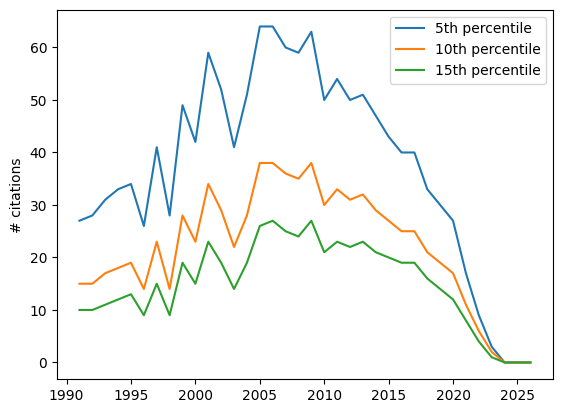

In [9]:

# importing package 
import matplotlib.pyplot as plt 

df = percentiles[percentiles['year'] > 1990]
df = df.sort_values(by=['year', 'percentile'],ignore_index=True)
# create data 
y15 = df[df['percentile']==15]['citationcount']
y10 = df[df['percentile']==10]['citationcount']
y5 = df[df['percentile']==5]['citationcount']
x = df[df['percentile']==10]['year']
  
# plot line 
plt.plot(x, y5, label='5th percentile') 
plt.plot(x, y10, label='10th percentile') 
plt.plot(x, y15, label='15th percentile') 
plt.legend()
plt.ylabel('# citations')
plt.show()


In [ ]:
x

# BLURRING your credentials

In [ ]:

import os, json

def get_credentials():
    with open(os.path.expanduser("~/.credentials.json"), "r") as read_file:
        credentials = json.load(read_file)
    return credentials

def blur_credentials(credentials):
    for sensitive_key in ['password', 'apiKey', 'key', 'fingerprint']:
        if sensitive_key in credentials:
            credentials[sensitive_key] = '****'
            
    for key, value in credentials.items():
        if isinstance(value, dict):
            blur_credentials(value)
            

creds = get_credentials()
blur_credentials(creds)
print(json.dumps(creds, indent=4))